https://github.com/jwilsson/spotify-web-api-php/blob/main/docs/examples/working-with-scopes.md
https://docs.google.com/document/d/1Fy9aKwfZ1OY6RmsmPCBHVnkZGVKqVPyaYz9ScJlVb6U/edit

# Authorization & Set-up

In [146]:
import os
import requests
import base64
from dotenv import load_dotenv
import json
from urllib.parse import urlencode
import pandas as pd
import matplotlib.pyplot as plt 
import random

In [147]:
AUTH_URL = 'https://accounts.spotify.com/api/token'
BASE_URL = 'https://api.spotify.com/v1/'

In [171]:
def getAuth():
    # Retrieve client ID & secret from env file & encode.
    dotenv_path = '/Users/keegankelly/NYU/Classes/Advanced_Python/project/advanced_python/dvanced_python.env' # Remove.
    load_dotenv()
    # print(os.getenv('your-client-id'))
    # print(os.getenv('your-client-secret'))
    
    client_id, client_secret = os.environ.get('your-client-id'), os.environ.get('your-client-secret')
    credentials = f"{client_id}:{client_secret}"
    credentials_b64 = base64.b64encode(credentials.encode())
    
    url = 'https://accounts.spotify.com/api/token'
    token_data = {'grant_type': 'client_credentials'}
    headers = {
        'Content-Type': 'application/x-www-form-urlencoded',
        'Authorization': f'Basic {credentials_b64.decode()}'
    }
    
    response = requests.post(url, data=token_data, headers=headers)
    if response.ok:
        return response.json().get('access_token')
    else:
        print(f"Invalid: {response.status_code}, {response.text}")
        return None

# Playlist(S)

In [149]:
def getPlaylists(access_token):
    user_id = os.environ.get('user_id')
    headers = {
        "Authorization": f"Bearer {access_token}"
    }
    response = requests.get(f"{BASE_URL}users/{user_id}/playlists", headers=headers)
    if response.ok:
        return response.json()
    else:
        print(f"Invalid: {response.status_code}, {response.text}")
    return None

def dfPlaylists(user_playlists):
    df_playlists = pd.json_normalize(user_playlists['items'], sep = '_', record_prefix = 'playlist_', errors = 'ignore')
    return df_playlists

def getColumns(df, relevant_columns):
    cleaned_columns = [col for col in relevant_columns if col in df.columns]
    return df[cleaned_columns]

In [150]:
def getPlaylist(playlist_id, access_token):
    headers = {
    "Authorization": f"Bearer {access_token}"
    }

    response = requests.get(f"{BASE_URL}playlists/{playlist_id}", headers=headers)
    if response.ok:
        return response.json()
    else:
        print(f"Invalid: {response.status_code}, {response.text}")
    return None

def dfPlaylist(json_data):
    playlist_info = {
    'playlist_name': json_data['name'],
    'total_tracks': json_data['tracks']['total'],
    'description': json_data['description'],
    'followers': json_data['followers']['total']
    }
        
    tracks = []
    for item in json_data['tracks']['items']:
        track = item['track']
        track_info = {
            'id': track['id'],
            'title': track['name'],
            'popularity': track['popularity'],
            'album': track['album']['name'],
            'release_date': track['album']['release_date'],
            'album_total_tracks': track['album']['total_tracks'],
            'artist': track['artists'][0]['name'] if track['artists'] else None,  # Assuming first artist as the main
            'artist_id': track['artists'][0]['id'] if track['artists'] else None, 
            'album_id': track['album']['id']
        }
        tracks.append(track_info)
    df_tracks = pd.DataFrame(tracks)
    return playlist_info, df_tracks

# Audio Features

In [151]:
def getAudiosFeatures(track_ids, access_token):

    track_ids = ",".join(track_ids) 
    headers = {
        "Authorization": f"Bearer {access_token}"
    }

    response = requests.get(f"{BASE_URL}audio-features?ids={track_ids}", headers=headers)
    if response.ok:
        return response.json()
    else:
        print(f"Invalid: {response.status_code}, {response.text}")
    return None

def audioFeaturesDf(audio_features_json): #Max 100 track ids.
    #if 'audio_features' key exists and use its value, otherwise use the input directly.
    features_list = audio_features_json['audio_features'] if 'audio_features' in audio_features_json else audio_features_json
    
    features_data = []
    for feature in features_list:
        if feature:  # if feature not None.
            features = {
                'danceability': feature['danceability'],
                'energy': feature['energy'],
                'key': feature['key'],
                'loudness': feature['loudness'],
                'mode': feature['mode'],
                'speechiness': feature['speechiness'],
                'acousticness': feature['acousticness'],
                'instrumentalness': feature['instrumentalness'],
                'liveness': feature['liveness'],
                'valence': feature['valence'],
                'tempo': feature['tempo'],
                'duration_ms': feature['duration_ms'],
                'time_signature': feature['time_signature']
            }
            # Include track ID as the dictionary key if present.
            if 'id' in feature:
                features['id'] = feature['id']
            features_data.append(features)
    
    df_features = pd.DataFrame(features_data)
    if 'id' in df_features.columns:
        df_features.set_index('id', inplace=True)
    return df_features


# Artist(S)

In [152]:
def getArtist(artist_ids, access_token):

    artist_ids = ",".join(artist_ids) 
    headers = {
        "Authorization": f"Bearer {access_token}"
    }
    response = requests.get(f"{BASE_URL}artists?ids={artist_ids}", headers=headers)
    if response.ok:
        return response.json()
    else:
        print(f"Invalid: {response.status_code}, {response.text}")
    return None

def ArtistDf(artist_json):       
    artists = []
    for artist in artist_json['artists']:
        artist_info = {
            'followers': artist['followers']['total'],
            'genre': random.choice(artist['genres']) if artist['genres'] else None, #maybe we want to keep these all? seem to be in alphabetical order so can't pick 'top genre'
            'id': artist['id'],
            'name': artist['name'],
            'popularity': artist['popularity']
        }
        artists.append(artist_info)
    df_artists = pd.DataFrame(artists)
    return df_artists

# Testing

In [172]:
access_token = getAuth()
user_playlists = getPlaylists(access_token)
tmp_df = dfPlaylists(user_playlists)
playlists_original_df = getColumns(tmp_df,['id','name', 'tracks_total'])
playlists_original_df.head()

{'href': 'https://api.spotify.com/v1/users/none/playlists?offset=0&limit=20', 'items': [], 'limit': 20, 'next': None, 'offset': 0, 'previous': None, 'total': 0}


""


In [154]:
#df of playlist
playlist = getPlaylist('2NhLGiv2PHFUIbnOZHWNMa', access_token)
info, df_tracks = dfPlaylist(playlist)
df_tracks.head(100)  

,id,title,popularity,album,release_date,album_total_tracks,artist,artist_id,album_id
0,1mQ3ryvTBSWeEMkH0Ul4gK,Calibre,49,Lô Borges,1972-01-01,15,Lô Borges,1mZbRiSVb2ExneAlDbBiiT,0fXZAZ5XejnxhgRV38SH5I
1,38dNnsL9yYygLYiX5ORf6B,FRENCH BOSSA NOVA,52,FRENCH BOSSA NOVA,2023-08-25,1,Ladji Mouflet,2NNTIDSDRlsf4lzYW9fpKm,1U25ArvtrbFkbAgke4NltV
2,21s0bjVrP7RtQskeUKZxOu,Soul Makossa,49,Manu Dibango Anthology,2000-01-01,34,Manu Dibango,30UIjoCGuL3Fa5BOc3ayNW,4WDsHhoLJTSGVAt7ydCoPN
3,7nZ9CzhiFRPhOQCn7eDSnn,Vanille fraise,62,Vanille fraise,2015,1,L'Impératrice,4PwlsrN0t5mLN0C827cbEU,41Ht5x3AgpMVmoFoIzaUPO
4,2xGlUVrlvnv4wf8AL3owDd,Vivre Pour Vivre - Instrumental,42,Francis Lai: The Essential Film Music Collection,2011-02-07,20,フランシス・レイ,7ENooSqJ9fshrkOLQwaofM,5Q1wvUO3Gw8qIfEbVn2KBB
5,6A9YFkei6zWfPSxWxlBecY,September Rain - 2020 Remaster,50,COLLECTION,2020-03-25,12,Makoto Matsushita,5qm3bAgsYq5aBOymqkM4gG,2jlyowwrLvyN28JGsu4or2
6,67wcAJeaNwGm0fcB4HzzYm,Everything Goes My Way,60,The English Riviera,2011-04-11,11,Metronomy,54QMjE4toDfiCryzYWCpXX,716fnrS2qXChPC3J2X73pK
7,6Xk5AaN4n4SnW71473GI7A,Fast Slow Disco,49,Fast Slow Disco,2018-06-01,1,St. Vincent,7bcbShaqKdcyjnmv4Ix8j6,1uuB4aCSbe5h5ga0wKUi3q
8,4gqDN1M6lY1Dzkr2N0pZDI,Hey Boy,39,Feelings,2021-02-26,11,Brijean,2TRNyrjoKJnqSc9G8jCZfb,0gmjvJvdWuD3AFk9sZ02Yi
9,3ahBKaBhVNiRLOG9RAdwMo,Samba Blim,43,Samba Blim,1968-01-01,12,Tamba 4,4KtH5Ery1JspML3ECanPmZ,2N8i34T56xgmiuN3DI7f34


In [155]:
#df of artists
artists = getArtist(list(df_tracks.artist_id), access_token)
artists_df = ArtistDf(artists)
artists_df.head(100)

{'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/1mZbRiSVb2ExneAlDbBiiT'}, 'followers': {'href': None, 'total': 149772}, 'genres': ['bossa nova', 'mpb', 'musica popular mineira'], 'href': 'https://api.spotify.com/v1/artists/1mZbRiSVb2ExneAlDbBiiT', 'id': '1mZbRiSVb2ExneAlDbBiiT', 'images': [{'height': 640, 'url': 'https://i.scdn.co/image/ab6761610000e5eb48318cf43d3ab8384e35a465', 'width': 640}, {'height': 320, 'url': 'https://i.scdn.co/image/ab6761610000517448318cf43d3ab8384e35a465', 'width': 320}, {'height': 160, 'url': 'https://i.scdn.co/image/ab6761610000f17848318cf43d3ab8384e35a465', 'width': 160}], 'name': 'Lô Borges', 'popularity': 46, 'type': 'artist', 'uri': 'spotify:artist:1mZbRiSVb2ExneAlDbBiiT'}, {'external_urls': {'spotify': 'https://open.spotify.com/artist/2NNTIDSDRlsf4lzYW9fpKm'}, 'followers': {'href': None, 'total': 9849}, 'genres': [], 'href': 'https://api.spotify.com/v1/artists/2NNTIDSDRlsf4lzYW9fpKm', 'id': '2NNTIDSDRlsf4lzYW9fpKm', 'images'

,followers,genre,id,name,popularity
0,149772,musica popular mineira,1mZbRiSVb2ExneAlDbBiiT,Lô Borges,46
1,9849,None,2NNTIDSDRlsf4lzYW9fpKm,Ladji Mouflet,42
2,88238,makossa,30UIjoCGuL3Fa5BOc3ayNW,Manu Dibango,45
3,535975,french indietronica,4PwlsrN0t5mLN0C827cbEU,L'Impératrice,61
4,835,None,7ENooSqJ9fshrkOLQwaofM,フランシス・レイ,27
5,57453,classic city pop,5qm3bAgsYq5aBOymqkM4gG,Makoto Matsushita,46
6,1022803,neo-synthpop,54QMjE4toDfiCryzYWCpXX,Metronomy,63
7,834656,neo-synthpop,7bcbShaqKdcyjnmv4Ix8j6,St. Vincent,62
8,21079,oakland indie,2TRNyrjoKJnqSc9G8jCZfb,Brijean,41
9,5687,samba-jazz,4KtH5Ery1JspML3ECanPmZ,Tamba 4,39


In [176]:
#df of audio features
audio_features = getAudiosFeatures(list(df_tracks.id), access_token)
audio_features_df = audioFeaturesDf(audio_features)
audio_features_df.head(100)


{'audio_features': [{'danceability': 0.583, 'energy': 0.418, 'key': 1, 'loudness': -13.84, 'mode': 0, 'speechiness': 0.0296, 'acousticness': 0.797, 'instrumentalness': 0.96, 'liveness': 0.103, 'valence': 0.695, 'tempo': 122.853, 'type': 'audio_features', 'id': '1mQ3ryvTBSWeEMkH0Ul4gK', 'uri': 'spotify:track:1mQ3ryvTBSWeEMkH0Ul4gK', 'track_href': 'https://api.spotify.com/v1/tracks/1mQ3ryvTBSWeEMkH0Ul4gK', 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/1mQ3ryvTBSWeEMkH0Ul4gK', 'duration_ms': 89333, 'time_signature': 4}, {'danceability': 0.836, 'energy': 0.568, 'key': 4, 'loudness': -8.19, 'mode': 0, 'speechiness': 0.104, 'acousticness': 0.725, 'instrumentalness': 0.393, 'liveness': 0.127, 'valence': 0.51, 'tempo': 100.062, 'type': 'audio_features', 'id': '38dNnsL9yYygLYiX5ORf6B', 'uri': 'spotify:track:38dNnsL9yYygLYiX5ORf6B', 'track_href': 'https://api.spotify.com/v1/tracks/38dNnsL9yYygLYiX5ORf6B', 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/38dNnsL9yYygLYiX5OR

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
id,,,,,,,,,,,,,
1mQ3ryvTBSWeEMkH0Ul4gK,0.583,0.418,1,-13.840,0,0.0296,0.7970,0.960000,0.1030,0.695,122.853,89333,4
38dNnsL9yYygLYiX5ORf6B,0.836,0.568,4,-8.190,0,0.1040,0.7250,0.393000,0.1270,0.510,100.062,230400,4
21s0bjVrP7RtQskeUKZxOu,0.831,0.835,0,-3.768,1,0.1420,0.1280,0.002270,0.1340,0.800,114.997,264307,4
7nZ9CzhiFRPhOQCn7eDSnn,0.767,0.547,7,-11.458,0,0.0474,0.0399,0.485000,0.0949,0.660,103.030,238183,4
2xGlUVrlvnv4wf8AL3owDd,0.495,0.245,0,-15.215,1,0.0288,0.8160,0.959000,0.1540,0.221,97.974,191360,3
6A9YFkei6zWfPSxWxlBecY,0.647,0.446,0,-7.089,1,0.0268,0.6610,0.001460,0.0846,0.252,124.030,271951,4
67wcAJeaNwGm0fcB4HzzYm,0.864,0.558,2,-8.196,0,0.0399,0.1020,0.001050,0.1780,0.544,129.969,210080,4
6Xk5AaN4n4SnW71473GI7A,0.606,0.828,10,-7.510,0,0.0577,0.0386,0.000148,0.3130,0.388,113.975,197005,4
4gqDN1M6lY1Dzkr2N0pZDI,0.732,0.927,8,-7.103,0,0.0573,0.1080,0.652000,0.3270,0.629,120.015,195999,4


# Charts

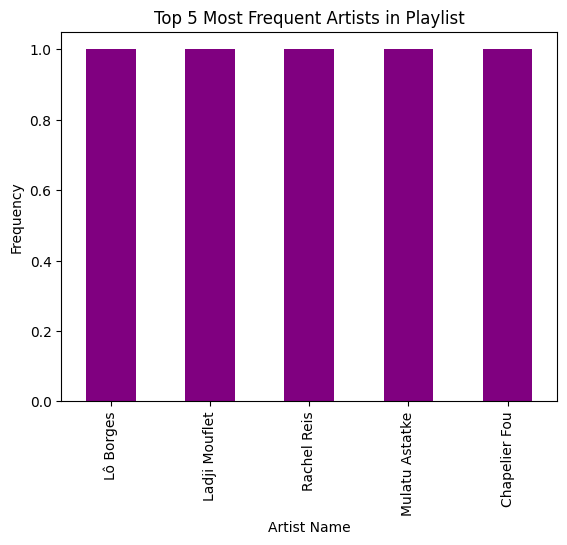

In [164]:
#most frequently occuring artists in our playlist 
def top_artists_chart(df_tracks):
    top_5_artists = df_tracks.artist.value_counts()[:5]
    top_5_artists.plot(kind='bar', color ='purple')
    plt.xlabel("Artist Name")
    plt.ylabel("Frequency")
    plt.title("Top 5 Most Frequent Artists in Playlist")
    plt.show()
top_artists_chart(df_tracks)

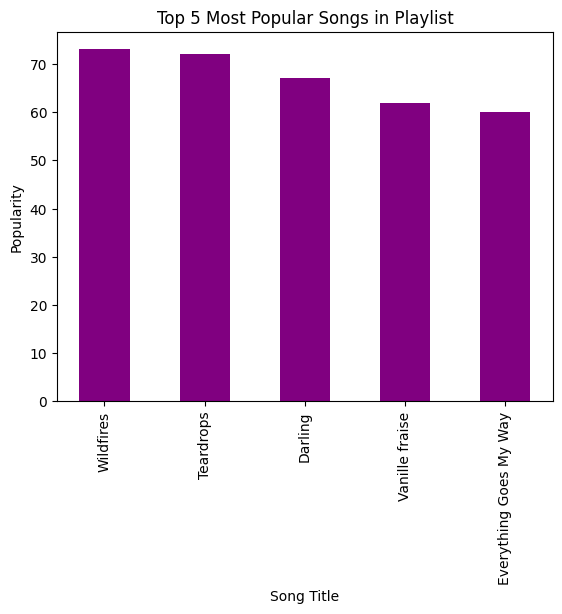

In [170]:
#most popular songs in our playlist
def top_songs_chart(df_tracks):
    top_5_songs = df_tracks.sort_values(ascending=False,by='popularity')[:5]
    y = list(top_5_songs.popularity)
    x = list(top_5_songs.title)
    plt.bar(x, y, color ='purple', width = 0.5)
    plt.xlabel("Song Title")
    plt.xticks(rotation=90)
    plt.ylabel("Popularity")
    plt.title("Top 5 Most Popular Songs in Playlist")
    plt.show()

top_songs_chart(df_tracks)

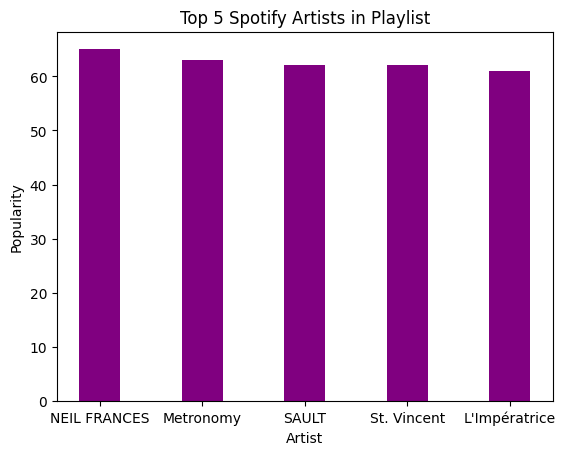

In [163]:
#most popular artists in our playlist according their Spotify popularity scores
def top_spotiy_artists_chart(artists_df):
    top_5_artists = artists_df.sort_values(ascending=False,by='popularity')[:5]
    y = list(top_5_artists.popularity)
    x = list(top_5_artists.name)
    plt.bar(x, y, color ='purple', width = 0.4)
    plt.xlabel("Artist")
    plt.ylabel("Popularity")
    plt.title("Top 5 Spotify Artists in Playlist")
    plt.show()

top_spotiy_artists_chart(artists_df)



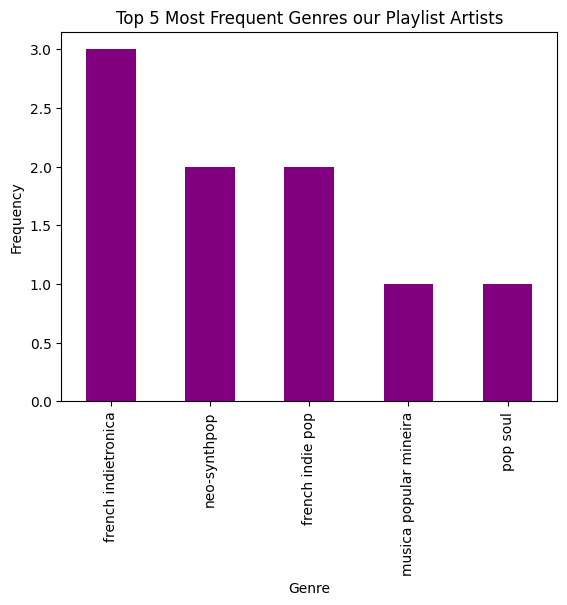

In [197]:
#get most frequently occuring artists 
def top_genre_chart(artists_df):
    top_5_genres = artists_df.genre.value_counts()[:5]
    top_5_genres.plot(kind='bar', color ='purple')
    plt.xlabel("Genre")
    plt.ylabel("Frequency")
    plt.title("Top 5 Most Frequent Genres our Playlist Artists")
    plt.show()
top_genre_chart(artists_df)

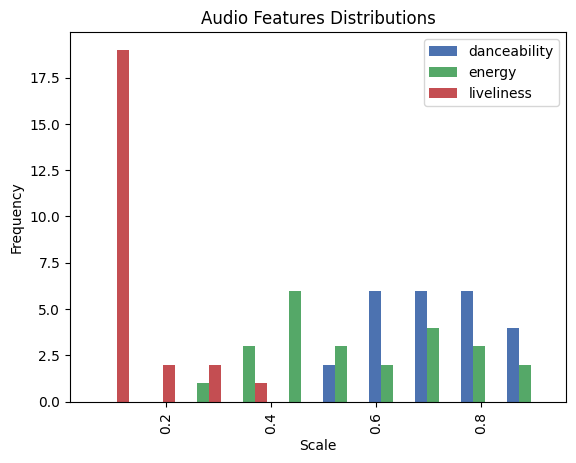

In [207]:
plt.style.use('seaborn-deep')

#histogram of our audio faetures
def audio_features_dist(audio_features_df):
    plt.hist([audio_features_df.danceability, audio_features_df.energy, audio_features_df.liveness], label=['danceability', 'energy', 'liveliness'])
    plt.xlabel("Scale")
    plt.xticks(rotation=90)
    plt.ylabel("Frequency")
    plt.title("Audio Features Distributions")
    plt.legend(loc='upper right')
    plt.show()

audio_features_dist(audio_features_df)

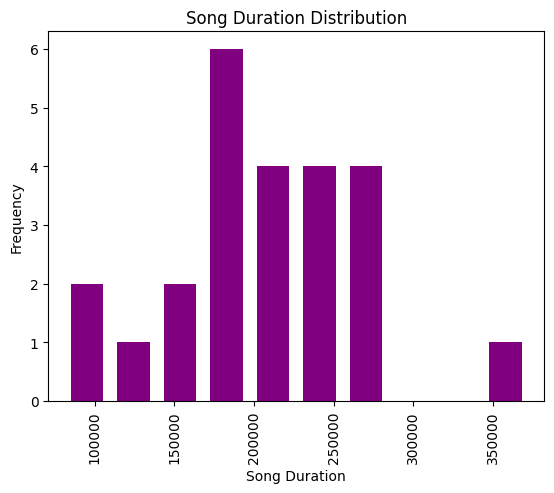

In [205]:
#histogram of song duration
def audio_features_dist(audio_features_df):
    plt.hist(audio_features_df.duration_ms, color='purple', rwidth=0.7)
    plt.xlabel("Song Duration")
    plt.xticks(rotation=90)
    plt.ylabel("Frequency")
    plt.title("Song Duration Distribution")
    plt.show()

audio_features_dist(audio_features_df)